# Bulk RNA-seq Stability Analysis (No Filter)

## Analysis Overview
This notebook performs comprehensive stability analysis of bulk RNA-seq data from iNeuron differentiation time-course experiments **without gene filtering**. This analysis complements the filtered version by examining the full gene expression landscape.

### Key Objectives
1. **Hierarchical Clustering**: Sample clustering based on unfiltered PCA distance matrices
2. **Marker Gene Analysis**: Identification and visualization of sample-specific markers (unfiltered)
3. **Temporal Analysis**: Time-course gene expression patterns across all genes
4. **Single-cell Integration**: Comparison with single-cell derived marker genes
5. **Cross-validation**: Bulk vs single-cell marker overlap analysis
6. **Timepoint-specific Analysis**: Focused analysis on D10 and D28 timepoints

### Input Data
- **Distance Matrix**: `bulk/stability_time_deseq2_pca_distances_noFilter.tsv` - Unfiltered PCA distances
- **Metadata**: `bulk/stability_timepoints_meta.tsv` - Sample annotations and timepoints
- **Expression**: `bulk/stability_timepoints.tsv` - Raw count matrix
- **VSD**: `bulk/stability_time_deseq2_vsd_noFilter.tsv` - Unfiltered variance stabilized data
- **Markers**: `stability_plots/{sample}_deseq2.tsv` - Sample-specific DEGs
- **SC Markers**: Single-cell derived marker genes for comparison

### Output Files
- `stability_plots/dendrogram_colored_by_sample_noFilter.png` - Hierarchical clustering dendrogram
- `stability_plots/dendrogram_colored_by_sample_heatmap_markers_noFilter.png` - Dendrogram-ordered heatmap
- `stability_plots/sample_heatmap_markers_sorted_noFilter.png` - Sample marker heatmap
- `stability_plots/sample_heatmap_markers_time_sorted_noFilter.png` - Temporal marker heatmap
- `stability_plots/sample_heatmap_screen_markers_sorted.png` - SC-derived markers heatmap

### Analysis Parameters
- **Top Markers per Sample**: 10 genes (initial analysis), 100 genes (extended)
- **Time Genes**: Top 40 early + 40 late responsive genes
- **Clustering Method**: Ward linkage on unfiltered PCA distances
- **Heatmap Normalization**: Z-score and min-max scaling

### Differences from Filtered Analysis
- Uses unfiltered variance stabilized data (`vsd_noFilter.tsv`)
- Analyzes complete gene expression profiles without pre-filtering
- May reveal additional patterns masked by filtering steps
- Includes timepoint-specific subset analyses (D10/D28)

---

## 1. Configuration

In [ ]:
# Configuration and Parameters
import os
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
import numpy as np
import random
np.random.seed(42)
random.seed(42)

# File paths
DATA_DIR = "bulk"
PLOTS_DIR = "stability_plots"
SC_DATA_DIR = "/home/jjanssens/jjans/analysis/iNeuron_morphogens/final"

# Input files (NoFilter variants)
DISTANCE_FILE = f"{DATA_DIR}/stability_time_deseq2_pca_distances_noFilter.tsv"
META_FILE = f"{DATA_DIR}/stability_timepoints_meta.tsv"
EXPR_FILE = f"{DATA_DIR}/stability_timepoints.tsv"
VSD_FILE = f"{DATA_DIR}/stability_time_deseq2_vsd_noFilter.tsv"  # NoFilter VSD data
TIME_DESEQ_FILE = f"{PLOTS_DIR}/deseq2_time.tsv"

# Single-cell reference files
SC_MARKERS_POST_FILE = f"{SC_DATA_DIR}/marker_genes/iGlut_post_dr_clustered_raw_merged_markers.tsv"
SC_META_POST_FILE = f"{SC_DATA_DIR}/scanpy/iGlut_post_dr_clustered_raw_merged_meta.tsv"
SC_MARKERS_PRE_FILE = f"{SC_DATA_DIR}/marker_genes/iGlut_pre_dr_clustered_raw_merged_markers.tsv"
SC_META_PRE_FILE = f"{SC_DATA_DIR}/scanpy/iGlut_pre_dr_clustered_raw_merged_meta_fixed.tsv"

# Analysis parameters
N_MARKERS_INITIAL = 10      # Top markers per sample for initial analysis
N_MARKERS_EXTENDED = 100    # Top markers per sample for extended analysis
N_TIME_GENES = 40          # Top early/late genes for temporal analysis
N_TOP_CLUSTERS = 3         # Top clusters per sample for SC analysis

# Plot parameters
FIGSIZE_LARGE = (20, 5)
FIGSIZE_DENDRO = (15, 4)
FIGSIZE_HEATMAP = (20, 9)
DPI = 350
HEATMAP_VMIN = 0
HEATMAP_VMAX = 2

# Sample to ID mapping
SAMPLE_TO_ID = {
    '1': 'p1_D4', '2': 'p1_D8', '3': 'p1_D10',
    '4': 'p1_B4', '5': 'p1_B8', '6': 'p1_B10',
    '7': 'p3_C2', '8': 'p3_F2', '9': 'p3_D1',
    '10': 'p3_F4', '11': 'p3_G1', '12': 'p3_G10'
}

# Timepoint subsets for focused analysis
TIMEPOINTS_ANALYSIS = ['d10', 'd28']

# Ensure output directory exists
os.makedirs(PLOTS_DIR, exist_ok=True)

print("Configuration loaded successfully!")
print(f"Random seed set to: 42")
print(f"Output directory: {PLOTS_DIR}")
print(f"Analysis type: NO FILTER (complete gene expression analysis)")
print(f"Analysis parameters:")
print(f"  - Markers per sample (initial): {N_MARKERS_INITIAL}")
print(f"  - Markers per sample (extended): {N_MARKERS_EXTENDED}")
print(f"  - Time genes (early/late): {N_TIME_GENES} each")
print(f"  - Timepoint subsets: {TIMEPOINTS_ANALYSIS}")

## 2. Import Libraries

In [ ]:
# Core libraries
import pandas as pd
import numpy as np
import os
import warnings

# Plotting libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical and clustering libraries
import scipy.spatial.distance as ssd
from scipy.cluster import hierarchy
import scipy.cluster.hierarchy as sch

# Set plotting style
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
sns.set_style("whitegrid")
sns.set_palette("Set2")

print("Libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Matplotlib version: {mpl.__version__}")
print(f"Seaborn version: {sns.__version__}")


## 3. Data Loading and Validation

In [ ]:
# Helper Functions
def load_data_with_validation(filepath, description="file"):
    """Load data file with validation and error handling."""
    try:
        if not os.path.exists(filepath):
            raise FileNotFoundError(f"{description} not found: {filepath}")
        
        data = pd.read_csv(filepath, sep="\t", index_col=0)
        print(f"✓ Loaded {description}: {data.shape}")
        return data
    except Exception as e:
        print(f"✗ Error loading {description}: {e}")
        return None

def square_to_condensed(square_matrix):
    """Convert square distance matrix to condensed form for clustering."""
    assert square_matrix.shape[0] == square_matrix.shape[1], "Distance matrix must be square"
    triu_indices = np.triu_indices(square_matrix.shape[0], k=1)
    condensed_matrix = square_matrix[triu_indices]
    return condensed_matrix

def create_sample_colors(sample_list):
    """Create color mapping for samples."""
    colors = ['red', 'green', 'blue', 'cyan', 'magenta', 'yellow', 'black', 
              'lightblue', 'orange', 'purple', 'brown', 'pink']
    
    color_map = {}
    for i, sample in enumerate(sorted(set(sample_list))):
        color = colors[i % len(colors)]
        color_map[sample] = color
    
    return color_map

def filter_samples_by_timepoint(samples, timepoint):
    """Filter samples by specific timepoint."""
    return [s for s in samples if timepoint in s]

print("Helper functions defined successfully!")

In [ ]:
# Load main bulk RNA-seq data (NoFilter variants)
print("Loading bulk RNA-seq stability data (unfiltered)...")

# Load distance matrix (taking the final corrT version)
distance_df = load_data_with_validation(DISTANCE_FILE, "PCA distance matrix (noFilter)")

# Load metadata and expression data
meta_df = load_data_with_validation(META_FILE, "sample metadata")
expr_df = load_data_with_validation(EXPR_FILE, "expression matrix")
vsd_df = load_data_with_validation(VSD_FILE, "variance stabilized data (noFilter)")

# Validate data consistency
if all(df is not None for df in [distance_df, meta_df, expr_df, vsd_df]):
    print(f"\nData validation:")
    print(f"Distance matrix: {distance_df.shape}")
    print(f"Metadata: {meta_df.shape}")
    print(f"Expression: {expr_df.shape}")
    print(f"VSD data (noFilter): {vsd_df.shape}")
    
    # Check sample consistency
    common_samples = set(distance_df.index) & set(meta_df.index) & set(vsd_df.columns)
    print(f"Common samples across datasets: {len(common_samples)}")
    
    # Compare with filtered data expectations
    print(f"\nNoFilter dataset characteristics:")
    print(f"  - Genes in unfiltered VSD: {vsd_df.shape[0]}")
    print(f"  - This includes all expressed genes without filtering")
    
    if len(common_samples) > 0:
        print("✓ NoFilter data loading completed successfully!")
    else:
        print("✗ Warning: No common samples found across datasets!")
else:
    raise ValueError("Failed to load required data files!")

## 4. Sample Marker Gene Analysis

In [ ]:
# Load sample-specific marker genes from DESeq2 analysis
print("Loading sample-specific marker genes...")

def load_sample_markers(sample_ids, n_markers=N_MARKERS_INITIAL, log_fc_threshold=0):
    """Load top marker genes for each sample."""
    all_markers = []
    successful_samples = []
    
    for sample_id in sample_ids:
        marker_file = f"{PLOTS_DIR}/{sample_id}_deseq2.tsv"
        
        try:
            if os.path.exists(marker_file):
                marker_df = pd.read_csv(marker_file, sep="\t", index_col=0)
                
                # Filter for positive fold changes and sort by significance
                marker_df_pos = marker_df.loc[marker_df['log2FoldChange'] > log_fc_threshold]
                marker_df_sig = marker_df_pos.sort_values(by='padj')
                
                # Get top markers
                top_markers = list(marker_df_sig.head(n=n_markers).index)
                all_markers.extend(top_markers)
                successful_samples.append(sample_id)
                
                print(f"  Sample {sample_id}: {len(top_markers)} markers loaded")
            else:
                print(f"  Warning: Marker file not found for sample {sample_id}")
                
        except Exception as e:
            print(f"  Error loading markers for sample {sample_id}: {e}")
    
    print(f"\nTotal unique markers collected: {len(set(all_markers))}")
    print(f"Samples processed successfully: {len(successful_samples)}")
    
    return all_markers, successful_samples

# Load markers for all samples
unique_samples = sorted(set(meta_df['sample']))
print(f"Loading markers for {len(unique_samples)} samples...")

sample_markers_all, processed_samples = load_sample_markers(unique_samples)

# Verify markers exist in expression data
available_markers = [gene for gene in sample_markers_all if gene in vsd_df.index]
print(f"Markers available in VSD data: {len(available_markers)}/{len(sample_markers_all)}")

if len(available_markers) == 0:
    print("✗ Warning: No marker genes found in expression data!")
else:
    print("✓ Sample marker genes loaded successfully!")


## 5. Hierarchical Clustering Analysis

In [ ]:
import numpy as np
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

#set colors
colors = [
    'red',
    'green',
    'blue',
    'cyan',
    'magenta',
    'yellow',
    'black',
    'lightblue',
    'orange',
    'purple',
    'brown',
    'pink'
]

# Prepare hierarchical clustering
print("Preparing hierarchical clustering analysis...")

# Create sample color mapping
sample_color_map = create_sample_colors(meta_df['sample'])
print(f"Color mapping created for {len(sample_color_map)} unique samples")

# Create leaf color mapping (sample ID -> color)
leaf_colors = {}
for sample_id in meta_df.index:
    sample_group = meta_df.loc[sample_id, 'sample']
    leaf_colors[sample_id] = sample_color_map[sample_group]

print(f"Leaf color mapping created for {len(leaf_colors)} samples")

# Display color scheme
print("\nSample color scheme:")
for sample, color in sample_color_map.items():
    sample_count = sum(1 for s in meta_df['sample'] if s == sample)
    print(f"  Sample {sample}: {color} ({sample_count} timepoints)")

# Convert distance matrix to condensed form for clustering
print(f"\nPreparing distance matrix: {distance_df.shape}")
condensed_distance_matrix = square_to_condensed(distance_df.values)
print(f"Condensed distance matrix: {len(condensed_distance_matrix)} pairwise distances")

# Perform hierarchical clustering
linkage_matrix = sch.linkage(condensed_distance_matrix, method='ward')
print(f"Hierarchical clustering completed using Ward linkage")
print(f"Linkage matrix shape: {linkage_matrix.shape}")


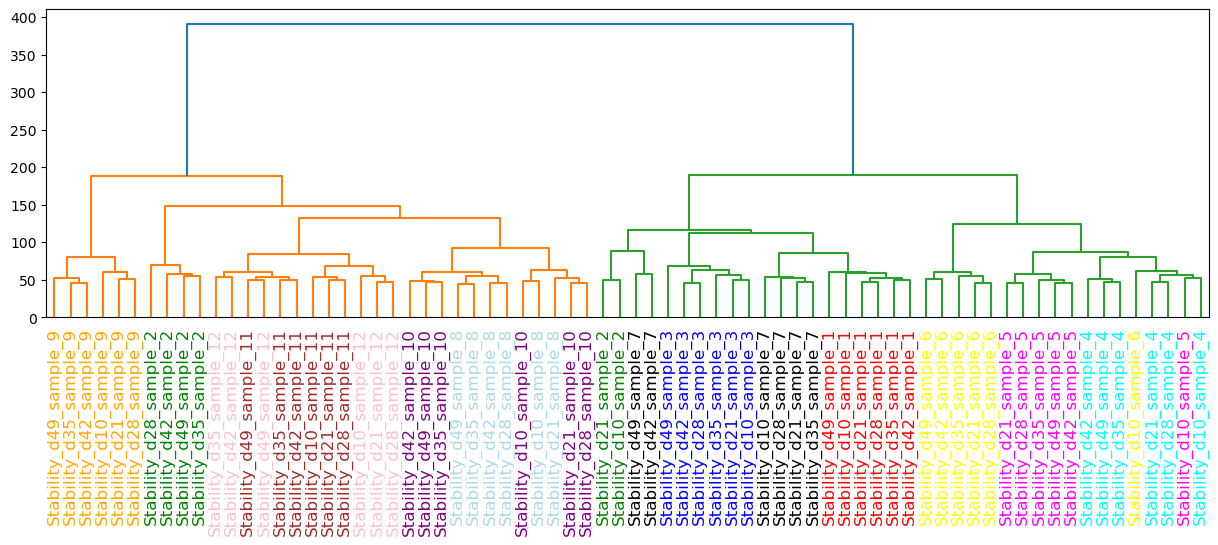

In [ ]:
# Create hierarchical clustering dendrogram
print("Creating dendrogram with sample-colored labels...")

plt.figure(figsize=FIGSIZE_DENDRO)

# Create dendrogram
dendrogram = sch.dendrogram(
    linkage_matrix,
    labels=distance_df.index,
    leaf_rotation=90,
    leaf_font_size=10,
    color_threshold=0
)

# Color the leaf labels by sample
ax = plt.gca()
x_labels = ax.get_xmajorticklabels()

dendrogram_labels = []
for label in x_labels:
    label_text = label.get_text()
    if label_text in leaf_colors:
        label.set_color(leaf_colors[label_text])
        dendrogram_labels.append(label_text)

plt.title('Hierarchical Clustering of Samples (No Filter)\n(Colored by Sample Group)', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Sample ID', fontsize=12)
plt.ylabel('Distance', fontsize=12)

# Add legend for sample colors
legend_elements = []
for sample, color in sample_color_map.items():
    legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', 
                                    markerfacecolor=color, markersize=8, 
                                    label=f'Sample {sample}'))

plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')

# Save plot
output_file = f"{PLOTS_DIR}/dendrogram_colored_by_sample_noFilter.png"
plt.savefig(output_file, dpi=DPI, bbox_inches='tight', pad_inches=0.1)
print(f"Dendrogram saved to: {output_file}")

plt.show()
plt.close()

print(f"✓ Dendrogram created with {len(dendrogram_labels)} samples")


## 6. Sample Marker Heatmap Analysis

In [ ]:
# Prepare heatmap data using dendrogram order
print("Preparing heatmap data for sample markers (dendrogram order)...")

# Use dendrogram order for samples (if available)
if 'dendrogram_labels' in locals() and len(dendrogram_labels) > 0:
    ordered_samples = dendrogram_labels
    print(f"Using dendrogram order: {len(ordered_samples)} samples")
else:
    # Fallback to sorted order
    ordered_samples = sorted([s for s in meta_df.index if s in vsd_df.columns])
    print(f"Using sorted order: {len(ordered_samples)} samples")

# Filter markers available in VSD data
if len(available_markers) > 0 and len(ordered_samples) > 0:
    # Create expression matrix for heatmap
    vsd_plot = vsd_df.loc[available_markers, ordered_samples]
    print(f"Expression matrix for heatmap: {vsd_plot.shape}")
    
    # Z-score normalization
    vsd_plot_z = (vsd_plot.T - vsd_plot.T.mean()) / vsd_plot.T.std()
    vsd_plot_z = vsd_plot_z.T  # Transpose back (genes x samples)
    
    print(f"Z-score normalized data: {vsd_plot_z.shape}")
    print(f"Z-score range: {vsd_plot_z.min().min():.2f} to {vsd_plot_z.max().max():.2f}")
    
    print("✓ Heatmap data (dendrogram order) prepared successfully!")
else:
    print("✗ Error: Insufficient data for heatmap preparation")


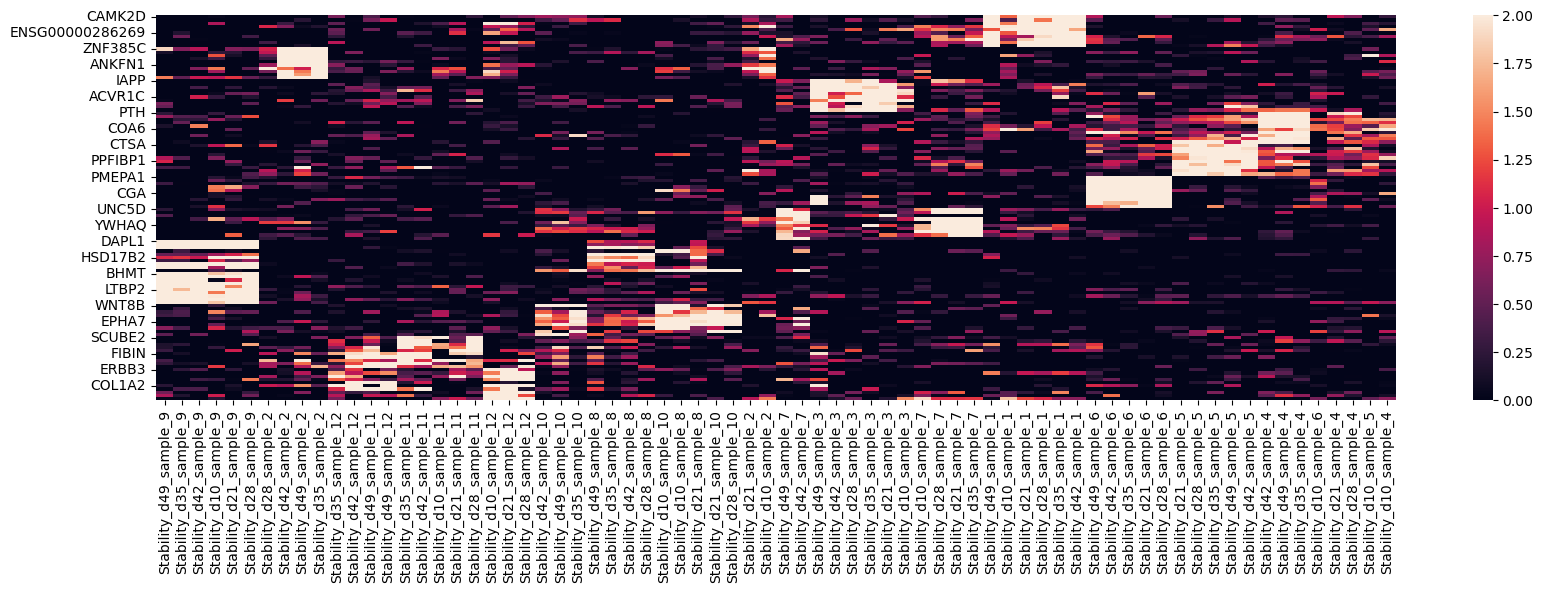

In [ ]:
# Create sample marker heatmap (dendrogram order)
print("Creating sample marker heatmap (dendrogram order)...")

if len(available_markers) > 0 and len(ordered_samples) > 0:
    plt.figure(figsize=FIGSIZE_LARGE)
    
    # Create heatmap
    sns.heatmap(vsd_plot_z, 
                vmin=HEATMAP_VMIN, vmax=HEATMAP_VMAX,
                cmap='viridis',
                xticklabels=True, yticklabels=False,
                cbar_kws={'label': 'Z-score'})
    
    plt.title('Sample Marker Expression Heatmap (No Filter)\n(Dendrogram Order)', 
              fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Sample ID', fontsize=12)
    plt.ylabel(f'Marker Genes (n={len(available_markers)})', fontsize=12)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=90, fontsize=8)
    
    # Save plot
    output_file = f"{PLOTS_DIR}/dendrogram_colored_by_sample_heatmap_markers_noFilter.png"
    plt.savefig(output_file, dpi=DPI, bbox_inches='tight', pad_inches=0.1)
    print(f"Heatmap saved to: {output_file}")
    
    plt.show()
    plt.close()
    
    print("✓ Dendrogram-ordered heatmap created successfully!")
else:
    print("✗ Error: Insufficient data for heatmap creation")


In [ ]:
# Prepare metadata-sorted samples for alternative heatmap view
print("Preparing metadata-sorted sample order...")

# Sort samples by metadata (sample group and timepoint)
meta_sorted = meta_df.sort_values(by=['sample', 't_int'])
sorted_samples_meta = [s for s in meta_sorted.index if s in vsd_df.columns]

print(f"Metadata-sorted samples: {len(sorted_samples_meta)}")

# Create timepoint-specific subsets for focused analysis
timepoint_subsets = {}
for timepoint in TIMEPOINTS_ANALYSIS:
    subset = filter_samples_by_timepoint(sorted_samples_meta, timepoint)
    timepoint_subsets[timepoint] = subset
    print(f"  {timepoint} samples: {len(subset)}")

print("✓ Sample ordering prepared successfully!")

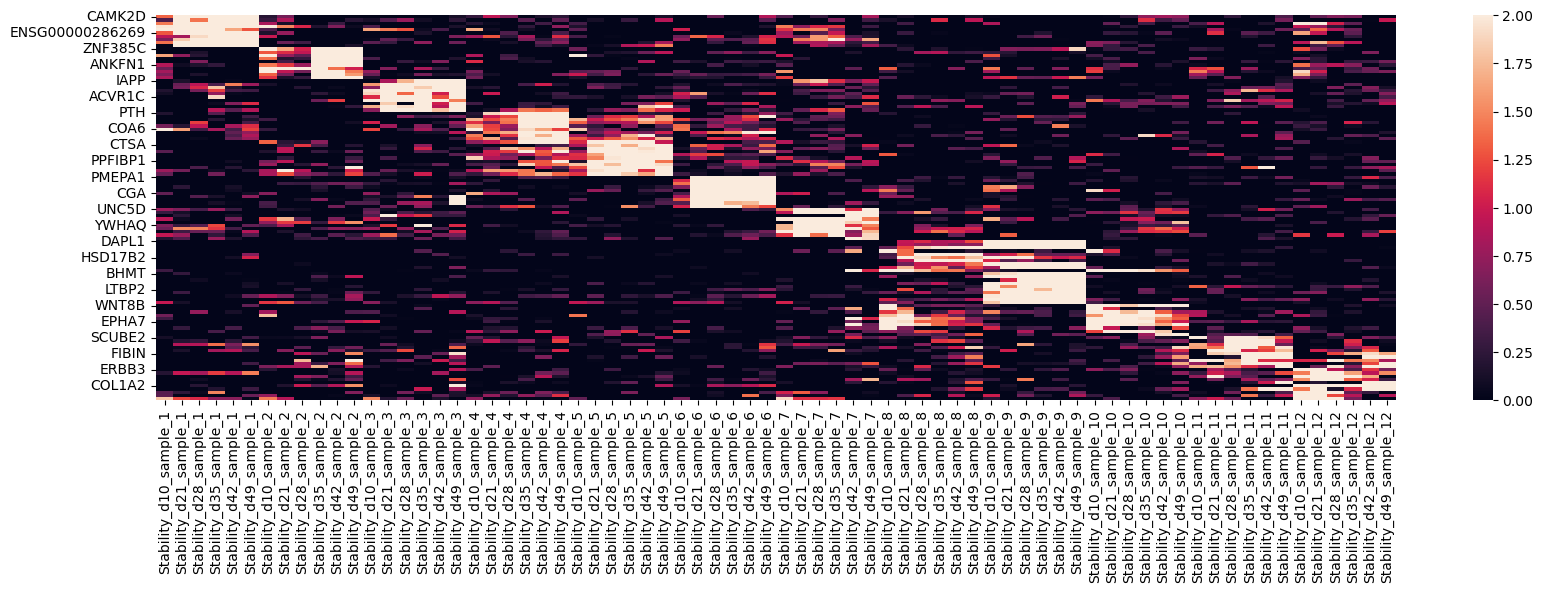

In [ ]:
# Create sample marker heatmap (metadata-sorted)
print("Creating sample marker heatmap with metadata sorting...")

if len(available_markers) > 0 and len(sorted_samples_meta) > 0:
    # Prepare data with metadata sorting
    vsd_plot_sorted = vsd_df.loc[available_markers, sorted_samples_meta]
    vsd_plot_sorted_z = (vsd_plot_sorted.T - vsd_plot_sorted.T.mean()) / vsd_plot_sorted.T.std()
    vsd_plot_sorted_z = vsd_plot_sorted_z.T  # Transpose back
    
    plt.figure(figsize=FIGSIZE_LARGE)
    
    # Create heatmap
    sns.heatmap(vsd_plot_sorted_z, 
                vmin=HEATMAP_VMIN, vmax=HEATMAP_VMAX,
                cmap='viridis',
                xticklabels=True, yticklabels=False,
                cbar_kws={'label': 'Z-score'})
    
    plt.title('Sample Marker Expression Heatmap (No Filter)\n(Sorted by Sample and Timepoint)', 
              fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Sample ID', fontsize=12)
    plt.ylabel(f'Marker Genes (n={len(available_markers)})', fontsize=12)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=90, fontsize=8)
    
    # Save plot
    output_file = f"{PLOTS_DIR}/sample_heatmap_markers_sorted_noFilter.png"
    plt.savefig(output_file, dpi=DPI, bbox_inches='tight', pad_inches=0.1)
    print(f"Heatmap saved to: {output_file}")
    
    plt.show()
    plt.close()
    
    print("✓ Metadata-sorted marker heatmap created successfully!")
else:
    print("✗ Error: Insufficient data for heatmap creation")


## 7. Temporal Gene Expression Analysis

In [ ]:
# Load and analyze temporal gene expression patterns
print("Loading temporal gene expression analysis...")

# Load time-course DESeq2 results
time_deseq_df = load_data_with_validation(TIME_DESEQ_FILE, "temporal DESeq2 results")

if time_deseq_df is not None:
    # Calculate signed p-values for ranking
    time_deseq_df['signed_pval'] = (np.sign(time_deseq_df['log2FoldChange']) * 
                                   -np.log10(time_deseq_df['pvalue']))
    
    print(f"Temporal analysis data: {time_deseq_df.shape}")
    print(f"Signed p-value range: {time_deseq_df['signed_pval'].min():.2f} to {time_deseq_df['signed_pval'].max():.2f}")
    
    # Identify early and late responsive genes
    early_genes = list(time_deseq_df.sort_values(by='signed_pval').index[:N_TIME_GENES])
    late_genes = list(time_deseq_df.sort_values(by='signed_pval', ascending=False).index[:N_TIME_GENES])
    
    print(f"Early responsive genes: {len(early_genes)}")
    print(f"Late responsive genes: {len(late_genes)}")
    
    # Combine temporal genes
    time_genes_all = early_genes + late_genes
    time_genes_available = [gene for gene in time_genes_all if gene in vsd_df.index]
    
    print(f"Total temporal genes: {len(time_genes_all)}")
    print(f"Available in VSD data (noFilter): {len(time_genes_available)}")
    
    print("✓ Temporal gene analysis completed!")
else:
    print("✗ Error: Could not load temporal analysis data")
    time_genes_available = []


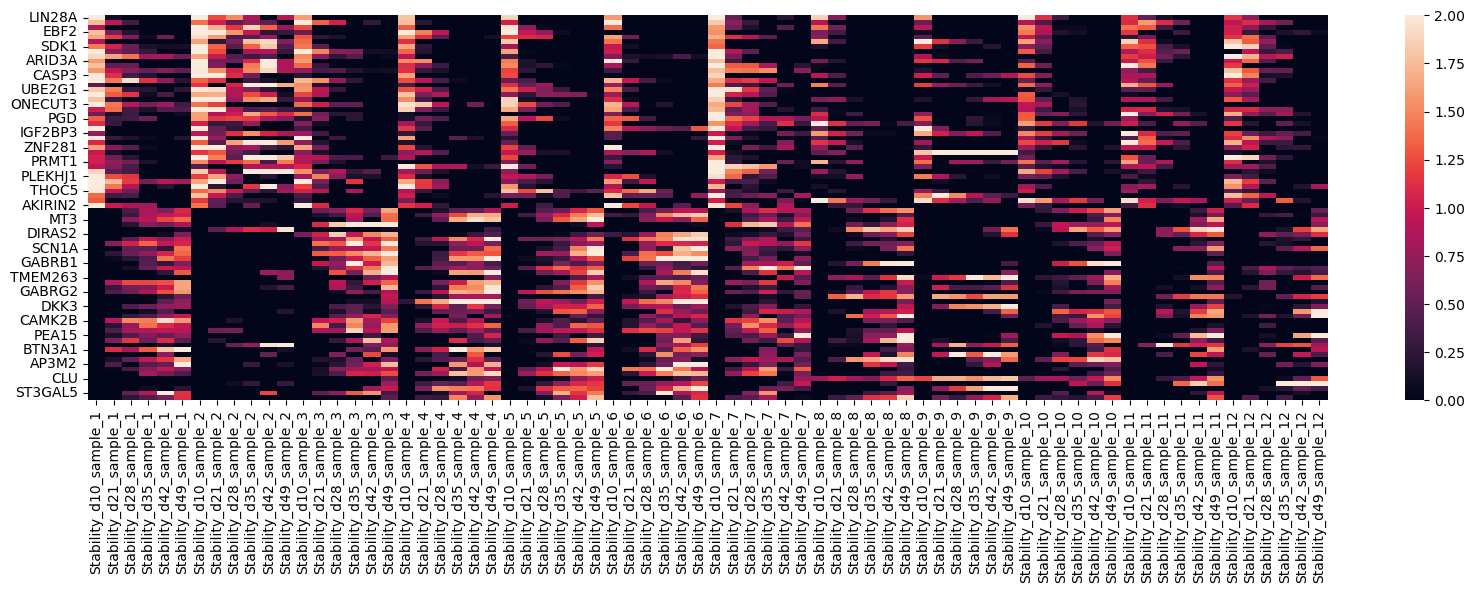

In [ ]:
# Create temporal gene expression heatmap
print("Creating temporal gene expression heatmap...")

if len(time_genes_available) > 0 and len(sorted_samples_meta) > 0:
    # Prepare temporal heatmap data
    vsd_temporal = vsd_df.loc[time_genes_available, sorted_samples_meta]
    vsd_temporal_z = (vsd_temporal.T - vsd_temporal.T.mean()) / vsd_temporal.T.std()
    vsd_temporal_z = vsd_temporal_z.T  # Transpose back
    
    plt.figure(figsize=FIGSIZE_LARGE)
    
    # Create heatmap
    sns.heatmap(vsd_temporal_z, 
                vmin=HEATMAP_VMIN, vmax=HEATMAP_VMAX,
                cmap='RdBu_r',
                xticklabels=True, yticklabels=False,
                cbar_kws={'label': 'Z-score'})
    
    plt.title('Temporal Gene Expression Heatmap (No Filter)\n(Early and Late Responsive Genes)', 
              fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Sample ID', fontsize=12)
    plt.ylabel(f'Temporal Genes (n={len(time_genes_available)})', fontsize=12)
    
    # Rotate x-axis labels
    plt.xticks(rotation=90, fontsize=8)
    
    # Add horizontal line to separate early/late genes
    if len(early_genes) > 0:
        early_available = [gene for gene in early_genes if gene in time_genes_available]
        if len(early_available) > 0:
            plt.axhline(y=len(early_available), color='white', linewidth=2, linestyle='--', alpha=0.8)
    
    # Save plot
    output_file = f"{PLOTS_DIR}/sample_heatmap_markers_time_sorted_noFilter.png"
    plt.savefig(output_file, dpi=DPI, bbox_inches='tight', pad_inches=0.1)
    print(f"Temporal heatmap saved to: {output_file}")
    
    plt.show()
    plt.close()
    
    print("✓ Temporal gene heatmap created successfully!")
else:
    print("✗ Error: Insufficient data for temporal heatmap creation")


## 8. Single-cell Data Integration

In [ ]:
# Define file paths
SC_MARKERS_POST_FILE = "/home/jjanssens/jjans/analysis/iNeuron_morphogens/final/marker_genes/iGlut_post_dr_clustered_raw_merged_markers.tsv"
SC_META_POST_FILE = "/home/jjanssens/jjans/analysis/iNeuron_morphogens/final/scanpy/iGlut_post_dr_clustered_raw_merged_meta.tsv"
SC_MARKERS_PRE_FILE = "/home/jjanssens/jjans/analysis/iNeuron_morphogens/final/marker_genes/iGlut_pre_dr_clustered_raw_merged_markers.tsv"
SC_META_PRE_FILE = "/home/jjanssens/jjans/analysis/iNeuron_morphogens/final/scanpy/iGlut_pre_dr_clustered_raw_merged_meta_fixed.tsv"

# Load single-cell reference data for comparison
print("Loading single-cell reference data...")

# Load single-cell marker genes and metadata
sc_markers_post = load_data_with_validation(SC_MARKERS_POST_FILE, "SC markers (post)")
sc_meta_post = load_data_with_validation(SC_META_POST_FILE, "SC metadata (post)")
sc_markers_pre = load_data_with_validation(SC_MARKERS_PRE_FILE, "SC markers (pre)")
sc_meta_pre = load_data_with_validation(SC_META_PRE_FILE, "SC metadata (pre)")

# Validate single-cell data
sc_data_available = all(df is not None for df in [sc_markers_post, sc_meta_post, 
                                                  sc_markers_pre, sc_meta_pre])

if sc_data_available:
    print("✓ Single-cell reference data loaded successfully!")
    
    # Filter for positive fold changes only
    sc_markers_post_filtered = sc_markers_post.loc[sc_markers_post['logfoldchanges'] > 0].copy()
    sc_markers_pre_filtered = sc_markers_pre.loc[sc_markers_pre['logfoldchanges'] > 0].copy()
    
    print(f"Filtered SC markers:")
    print(f"  Post-maturation: {sc_markers_post_filtered.shape[0]} genes")
    print(f"  Pre-maturation: {sc_markers_pre_filtered.shape[0]} genes")
    
    # Display sample info for reference
    if 'parse_id' in sc_meta_post.columns:
        post_samples = sc_meta_post['parse_id'].value_counts()
        print(f"  Post-maturation samples: {len(post_samples)}")
    
    if 'parse_id' in sc_meta_pre.columns:
        pre_samples = sc_meta_pre['parse_id'].value_counts()
        print(f"  Pre-maturation samples: {len(pre_samples)}")
        
else:
    print("✗ Warning: Single-cell reference data not available")
    print("Continuing analysis without SC integration...")

,sample,species,gene_count,tscp_count,mread_count,bc1_well,bc2_well,bc3_well,bc1_wind,bc2_wind,...,M_CHIR,M_RA,M_FGF8,M_BMP4,M_SHH,M_PM,tSNE_1,tSNE_2,umap_1,umap_2
01_01_41__s1,iGlut_pre,hg38,1456,2184,2946,A1,A1,D5,1,1,...,0.0,0,0,50,0,0,10.189884,39.231434,13.276781,-0.856798
01_01_68__s1,iGlut_pre,hg38,1693,2776,3762,A1,A1,F8,1,1,...,0.0,0,0,50,0,0,25.132082,32.402280,14.830362,5.908925
01_01_76__s1,iGlut_pre,hg38,1454,2196,2981,A1,A1,G4,1,1,...,0.0,0,0,50,0,0,5.797632,52.208040,16.393394,-1.702099
01_01_83__s1,iGlut_pre,hg38,2391,4048,5592,A1,A1,G11,1,1,...,0.0,0,0,50,0,0,6.855360,43.492870,13.618956,-2.668232
01_01_92__s1,iGlut_pre,hg38,769,1076,1503,A1,A1,H8,1,1,...,0.0,0,0,50,0,0,25.081343,29.805347,14.698254,5.868345


In [ ]:
# Single-cell marker integration analysis
print("Analyzing single-cell marker integration...")

if sc_data_available:
    def extract_sc_markers_for_sample(sample_id, sample_to_id_map, 
                                     sc_markers_df, sc_meta_df, n_markers=10):
        """Extract top marker genes from single-cell data for a given sample."""
        
        if str(sample_id) not in sample_to_id_map:
            print(f"  Warning: Sample {sample_id} not found in mapping")
            return []
        
        sc_sample_id = sample_to_id_map[str(sample_id)]
        
        # Find matching cells in metadata
        if 'parse_id' in sc_meta_df.columns:
            sample_cells = sc_meta_df.loc[sc_meta_df['parse_id'] == sc_sample_id]
            
            if len(sample_cells) == 0:
                print(f"  Warning: No cells found for {sc_sample_id}")
                return []
            
            # Get top clusters for this sample
            if 'final_clustering' in sample_cells.columns:
                top_clusters = sample_cells['final_clustering'].value_counts().head(N_TOP_CLUSTERS).index
                
                # Extract markers for top clusters
                sample_markers = []
                for cluster in top_clusters:
                    if 'cluster_old' in sc_markers_df.columns:
                        cluster_markers = sc_markers_df.loc[sc_markers_df['cluster_old'] == cluster]
                        top_cluster_markers = list(cluster_markers.index[:n_markers])
                        # Filter to genes available in bulk data
                        available_markers = [g for g in top_cluster_markers if g in vsd_df.index]
                        sample_markers.extend(available_markers)
                        
                print(f"  Sample {sample_id} ({sc_sample_id}): {len(sample_markers)} SC markers")
                return sample_markers
        
        return []
    
    # Process all samples
    unique_samples_str = [str(s) for s in sorted(set(meta_df['sample']))]
    sc_markers_all = []
    
    for sample in unique_samples_str:
        sample_id = SAMPLE_TO_ID.get(sample)
        
        if sample_id:
            if 'p1' in sample_id:  # Post-maturation
                markers = extract_sc_markers_for_sample(sample, SAMPLE_TO_ID, 
                                                       sc_markers_post_filtered, sc_meta_post)
            elif 'p3' in sample_id:  # Pre-maturation
                markers = extract_sc_markers_for_sample(sample, SAMPLE_TO_ID, 
                                                       sc_markers_pre_filtered, sc_meta_pre)
            else:
                markers = []
            
            sc_markers_all.extend(markers)
    
    # Remove duplicates
    sc_markers_unique = list(set(sc_markers_all))
    print(f"\nTotal unique SC markers collected: {len(sc_markers_unique)}")
    
    if len(sc_markers_unique) > 0:
        print("✓ Single-cell marker integration completed!")
    else:
        print("✗ Warning: No SC markers could be extracted")
        
else:
    sc_markers_unique = []
    print("Skipping SC marker integration (data not available)")

## 9. Comparative Heatmap Analysis

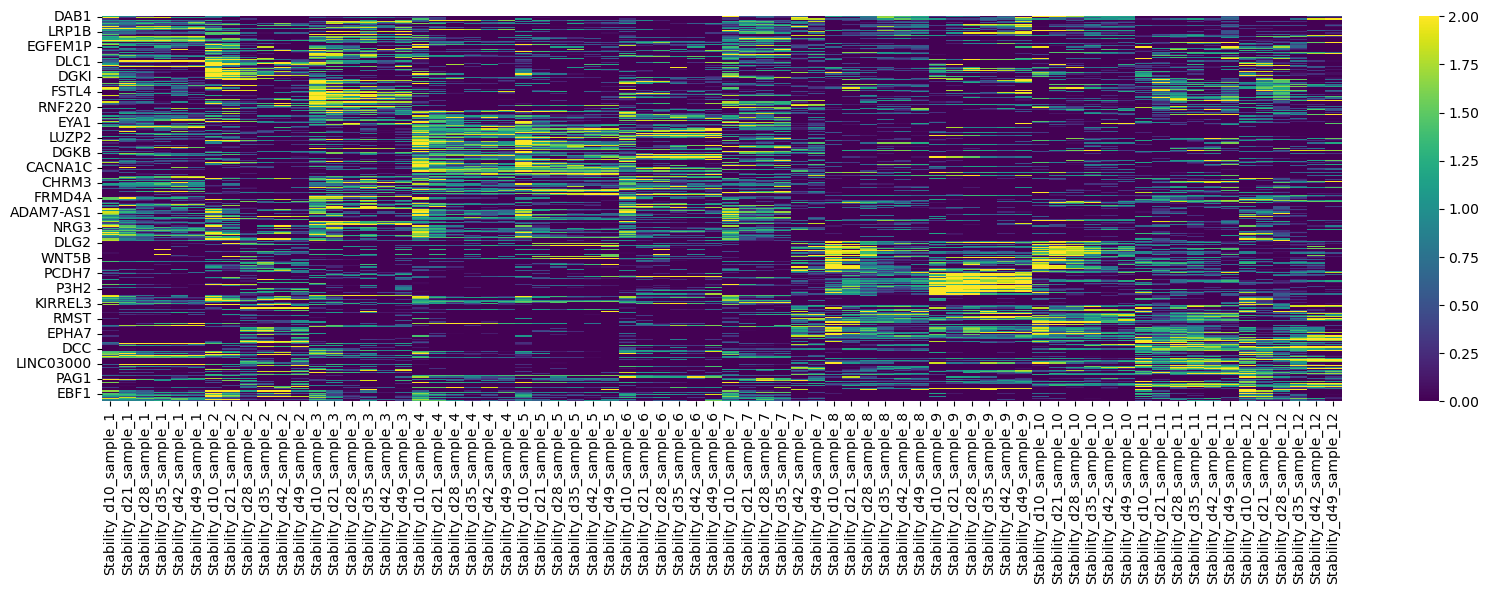

In [ ]:
# Create single-cell marker heatmap
print("Creating single-cell marker heatmap...")

if len(sc_markers_unique) > 0 and len(sorted_samples_meta) > 0:
    # Prepare SC marker heatmap data
    vsd_sc = vsd_df.loc[sc_markers_unique, sorted_samples_meta]
    vsd_sc_z = (vsd_sc.T - vsd_sc.T.mean()) / vsd_sc.T.std()
    vsd_sc_z = vsd_sc_z.T  # Transpose back
    
    plt.figure(figsize=FIGSIZE_LARGE)
    
    # Create heatmap
    sns.heatmap(vsd_sc_z, 
                vmin=HEATMAP_VMIN, vmax=HEATMAP_VMAX,
                cmap='viridis',
                xticklabels=True, yticklabels=False,
                cbar_kws={'label': 'Z-score'})
    
    plt.title('Single-cell Derived Marker Expression (No Filter)\n(Bulk RNA-seq Data)', 
              fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Sample ID', fontsize=12)
    plt.ylabel(f'SC-derived Markers (n={len(sc_markers_unique)})', fontsize=12)
    
    # Rotate x-axis labels
    plt.xticks(rotation=90, fontsize=8)
    
    # Save plot
    output_file = f"{PLOTS_DIR}/sample_heatmap_screen_markers_sorted.png"
    plt.savefig(output_file, dpi=DPI, bbox_inches='tight', pad_inches=0.1)
    print(f"SC marker heatmap saved to: {output_file}")
    
    plt.show()
    plt.close()
    
    print("✓ Single-cell marker heatmap created successfully!")
else:
    print("✗ Skipping SC marker heatmap (insufficient data)")



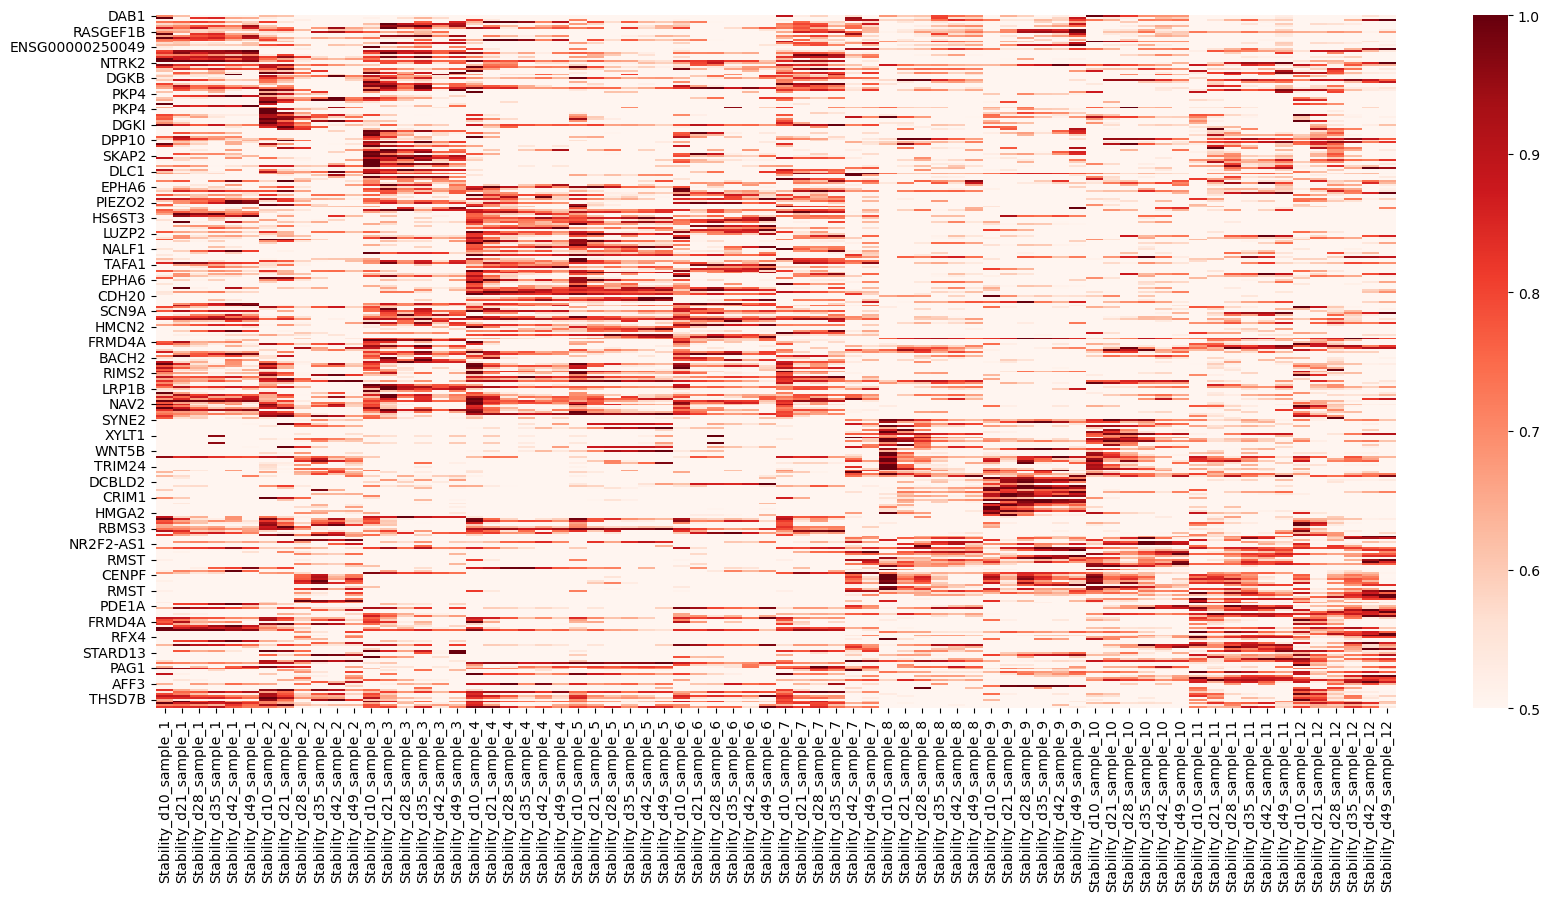

In [ ]:
# Create min-max normalized heatmap for SC markers
print("Creating min-max normalized heatmap...")

if len(sc_markers_unique) > 0 and len(sorted_samples_meta) > 0:
    # Min-max normalization
    vsd_sc_raw = vsd_df.loc[sc_markers_unique, sorted_samples_meta]
    vsd_sc_minmax = (vsd_sc_raw.T - vsd_sc_raw.T.min()) / (vsd_sc_raw.T.max() - vsd_sc_raw.T.min())
    vsd_sc_minmax = vsd_sc_minmax.T  # Transpose back
    
    plt.figure(figsize=FIGSIZE_HEATMAP)
    
    # Create heatmap with adjusted color range
    sns.heatmap(vsd_sc_minmax, 
                vmin=0.5, vmax=1.0,  # Focus on higher expression values
                cmap='Reds',
                xticklabels=True, yticklabels=False,
                cbar_kws={'label': 'Min-Max Normalized Expression'})
    
    plt.title('Single-cell Markers - Min-Max Normalized Expression (No Filter)\n(Highlighting High Expression)', 
              fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Sample ID', fontsize=12)
    plt.ylabel(f'SC-derived Markers (n={len(sc_markers_unique)})', fontsize=12)
    
    # Rotate x-axis labels
    plt.xticks(rotation=90, fontsize=8)
    
    # Save plot
    output_file = f"{PLOTS_DIR}/sc_markers_heatmap_minmax_noFilter.png"
    plt.savefig(output_file, dpi=DPI, bbox_inches='tight', pad_inches=0.1)
    print(f"Min-max heatmap saved to: {output_file}")
    
    plt.show()
    plt.close()
    
    print("✓ Min-max normalized heatmap created successfully!")
else:
    print("✗ Skipping min-max heatmap (insufficient data)")

## 10. Timepoint-specific Analysis

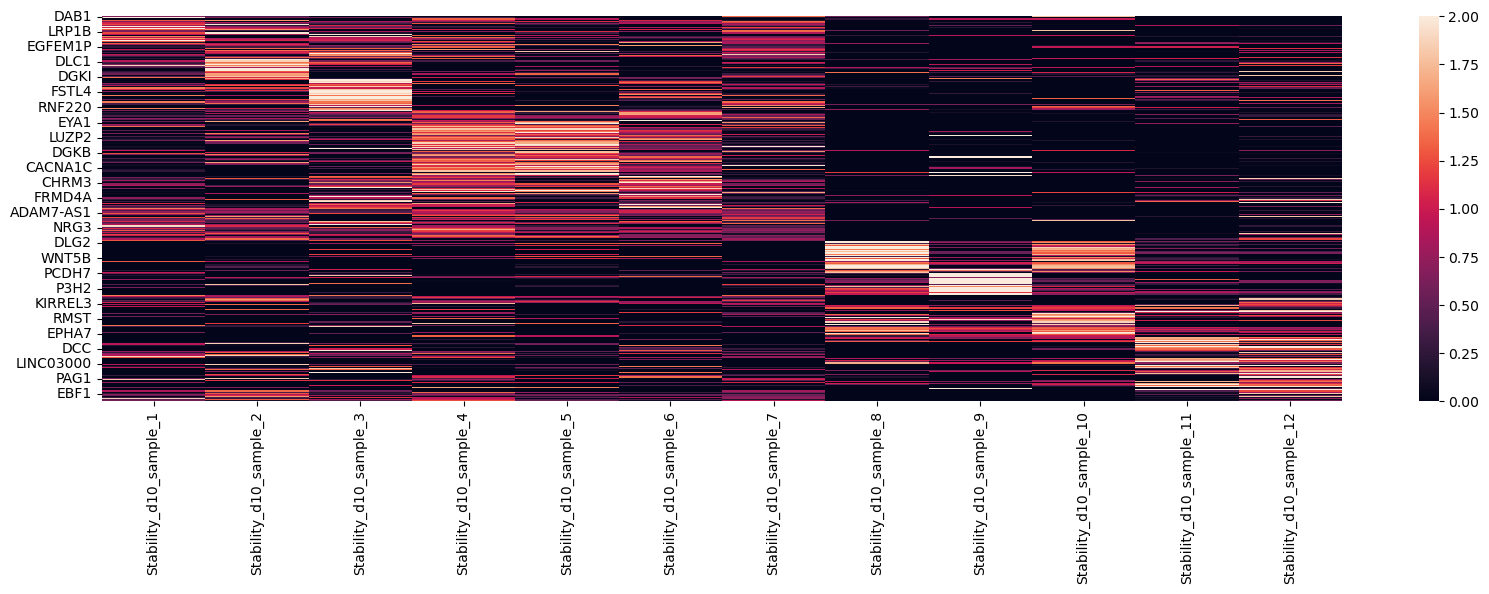

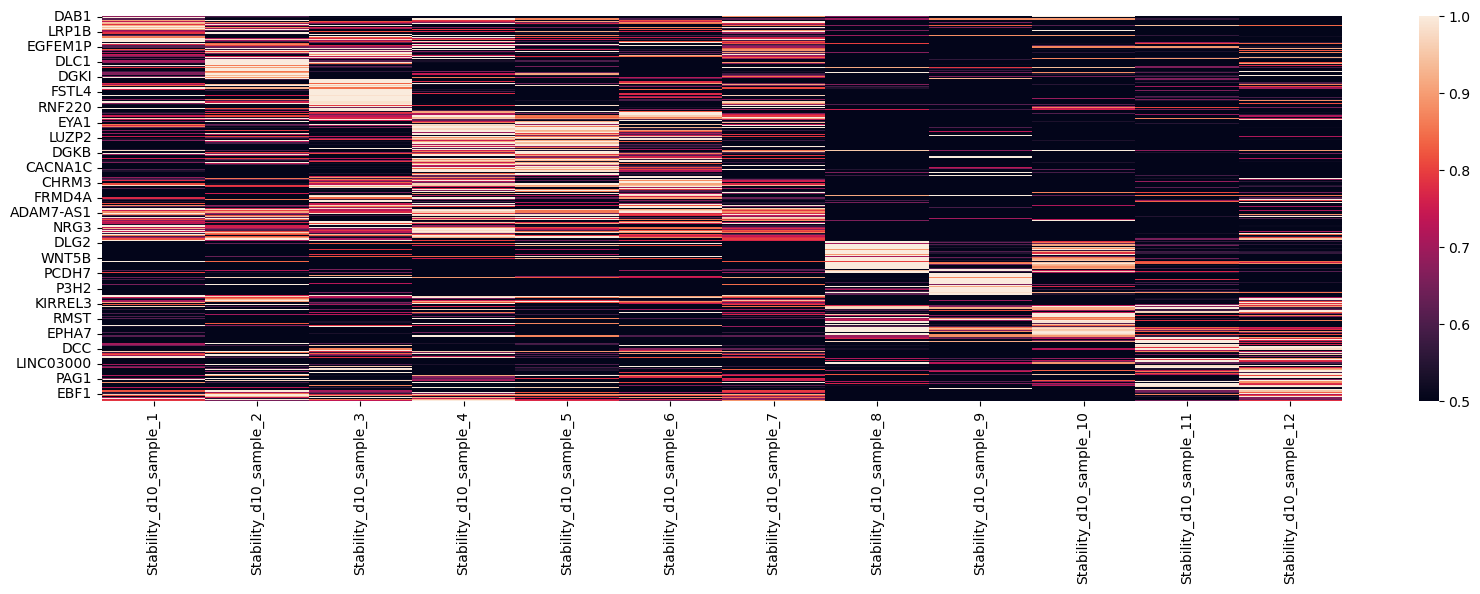

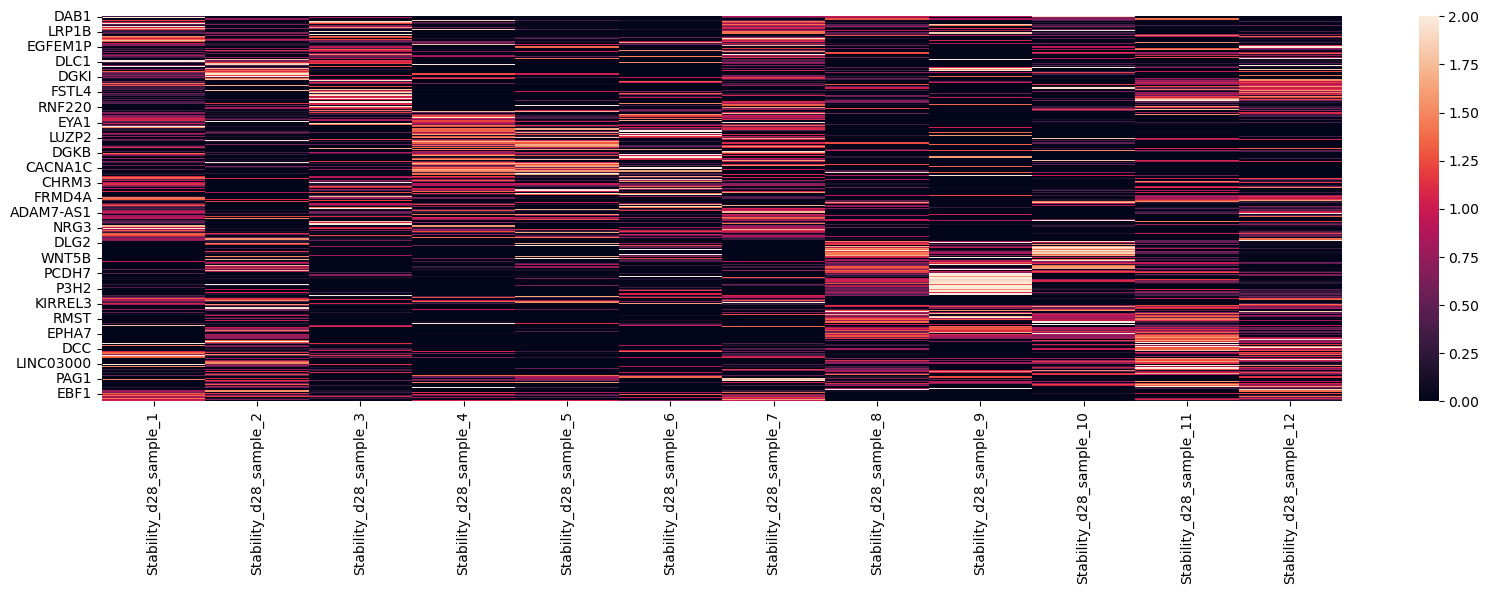

In [ ]:
# Timepoint-specific analysis for D10 and D28
print("Performing timepoint-specific analysis...")

if len(sc_markers_unique) > 0:
    for timepoint in TIMEPOINTS_ANALYSIS:
        timepoint_samples = timepoint_subsets.get(timepoint, [])
        
        if len(timepoint_samples) > 0:
            print(f"\nAnalyzing {timepoint} timepoint ({len(timepoint_samples)} samples)...")
            
            # Prepare data for this timepoint
            vsd_timepoint = vsd_df.loc[sc_markers_unique, timepoint_samples]
            
            if vsd_timepoint.shape[1] > 0:
                # Z-score normalization
                vsd_timepoint_z = (vsd_timepoint.T - vsd_timepoint.T.mean()) / vsd_timepoint.T.std()
                vsd_timepoint_z = vsd_timepoint_z.T  # Transpose back
                
                # Create Z-score heatmap
                plt.figure(figsize=FIGSIZE_LARGE)
                sns.heatmap(vsd_timepoint_z, 
                           vmin=HEATMAP_VMIN, vmax=HEATMAP_VMAX,
                           cmap='viridis',
                           xticklabels=True, yticklabels=False,
                           cbar_kws={'label': 'Z-score'})
                
                plt.title(f'SC Marker Expression - {timepoint.upper()} Timepoint (No Filter)\n(Z-score Normalized)', 
                          fontsize=14, fontweight='bold', pad=20)
                plt.xlabel('Sample ID', fontsize=12)
                plt.ylabel(f'SC-derived Markers (n={len(sc_markers_unique)})', fontsize=12)
                plt.xticks(rotation=90, fontsize=8)
                
                # Save plot
                output_file = f"{PLOTS_DIR}/sc_markers_heatmap_{timepoint}_zscore_noFilter.png"
                plt.savefig(output_file, dpi=DPI, bbox_inches='tight', pad_inches=0.1)
                print(f"  Z-score heatmap saved to: {output_file}")
                
                plt.show()
                plt.close()
                
                # Min-max normalization
                vsd_timepoint_minmax = (vsd_timepoint.T - vsd_timepoint.T.min()) / (vsd_timepoint.T.max() - vsd_timepoint.T.min())
                vsd_timepoint_minmax = vsd_timepoint_minmax.T  # Transpose back
                
                # Create min-max heatmap
                plt.figure(figsize=FIGSIZE_LARGE)
                sns.heatmap(vsd_timepoint_minmax, 
                           vmin=0.5, vmax=1.0,
                           cmap='Reds',
                           xticklabels=True, yticklabels=False,
                           cbar_kws={'label': 'Min-Max Normalized'})
                
                plt.title(f'SC Marker Expression - {timepoint.upper()} Timepoint (No Filter)\n(Min-Max Normalized)', 
                          fontsize=14, fontweight='bold', pad=20)
                plt.xlabel('Sample ID', fontsize=12)
                plt.ylabel(f'SC-derived Markers (n={len(sc_markers_unique)})', fontsize=12)
                plt.xticks(rotation=90, fontsize=8)
                
                # Save plot
                output_file = f"{PLOTS_DIR}/sc_markers_heatmap_{timepoint}_minmax_noFilter.png"
                plt.savefig(output_file, dpi=DPI, bbox_inches='tight', pad_inches=0.1)
                print(f"  Min-max heatmap saved to: {output_file}")
                
                plt.show()
                plt.close()
                
                print(f"  ✓ {timepoint} analysis completed")
            else:
                print(f"  ✗ No data available for {timepoint}")
        else:
            print(f"  ✗ No samples found for {timepoint}")
    
    print("\n✓ Timepoint-specific analysis completed!")
else:
    print("✗ Skipping timepoint analysis (no SC markers available)")



## 11. Cross-validation: Bulk vs Single-cell Markers

In [ ]:
# Load extended bulk markers for cross-validation
print("Loading extended bulk marker set for comparison...")

# Load more markers per sample for better comparison
bulk_markers_extended, _ = load_sample_markers(unique_samples, n_markers=N_MARKERS_EXTENDED)

print(f"Extended bulk markers: {len(bulk_markers_extended)} total")
print(f"Unique extended bulk markers: {len(set(bulk_markers_extended))}")

# Filter to available markers
bulk_markers_extended_available = [gene for gene in bulk_markers_extended if gene in vsd_df.index]
print(f"Available in VSD data (noFilter): {len(bulk_markers_extended_available)}")

if len(bulk_markers_extended_available) > 0:
    print("✓ Extended bulk markers loaded successfully!")
else:
    print("✗ Warning: No extended bulk markers available")

sample_markers_all_bulk = []
for i in set(meta['sample']):
    marker_df = pd.read_csv("stability_plots/"+str(i)+"_deseq2.tsv",sep="\t",index_col=0)
    marker_df_pos = marker_df.loc[marker_df['log2FoldChange']>0]
    marker_df_pos_sig = marker_df_pos.sort_values(by='padj')
    sample_markers = list(marker_df_pos_sig.head(n=100).index)
    sample_markers_all_bulk = sample_markers_all_bulk + sample_markers


In [ ]:
# Analyze marker overlap between bulk and single-cell data
print("Analyzing marker overlap between bulk and single-cell data...")

if len(bulk_markers_extended_available) > 0 and len(sc_markers_unique) > 0:
    # Find overlapping markers
    overlap_markers = [gene for gene in bulk_markers_extended_available if gene in sc_markers_unique]
    
    # Calculate overlap statistics
    bulk_set = set(bulk_markers_extended_available)
    sc_set = set(sc_markers_unique)
    overlap_set = set(overlap_markers)
    
    bulk_only = bulk_set - sc_set
    sc_only = sc_set - bulk_set
    
    print(f"\nMarker overlap analysis (NoFilter data):")
    print(f"  Bulk markers: {len(bulk_set)}")
    print(f"  SC markers: {len(sc_set)}")
    print(f"  Overlapping markers: {len(overlap_set)}")
    print(f"  Bulk-specific: {len(bulk_only)}")
    print(f"  SC-specific: {len(sc_only)}")
    
    # Calculate overlap percentages
    if len(bulk_set) > 0:
        bulk_overlap_pct = len(overlap_set) / len(bulk_set) * 100
        print(f"  Bulk overlap: {bulk_overlap_pct:.1f}%")
    
    if len(sc_set) > 0:
        sc_overlap_pct = len(overlap_set) / len(sc_set) * 100
        print(f"  SC overlap: {sc_overlap_pct:.1f}%")
    
    # Jaccard similarity
    union_size = len(bulk_set | sc_set)
    jaccard_similarity = len(overlap_set) / union_size if union_size > 0 else 0
    print(f"  Jaccard similarity: {jaccard_similarity:.3f}")
    
    if len(overlap_markers) > 0:
        print("✓ Marker overlap analysis completed!")
        overlap_available = True
    else:
        print("✗ Warning: No overlapping markers found!")
        overlap_available = False
        
else:
    print("✗ Skipping overlap analysis (insufficient data)")
    overlap_markers = []
    overlap_available = False

sample_markers_all_bulk_sc = [x for x in sample_markers_all_bulk if x in sample_markers_all_sc]

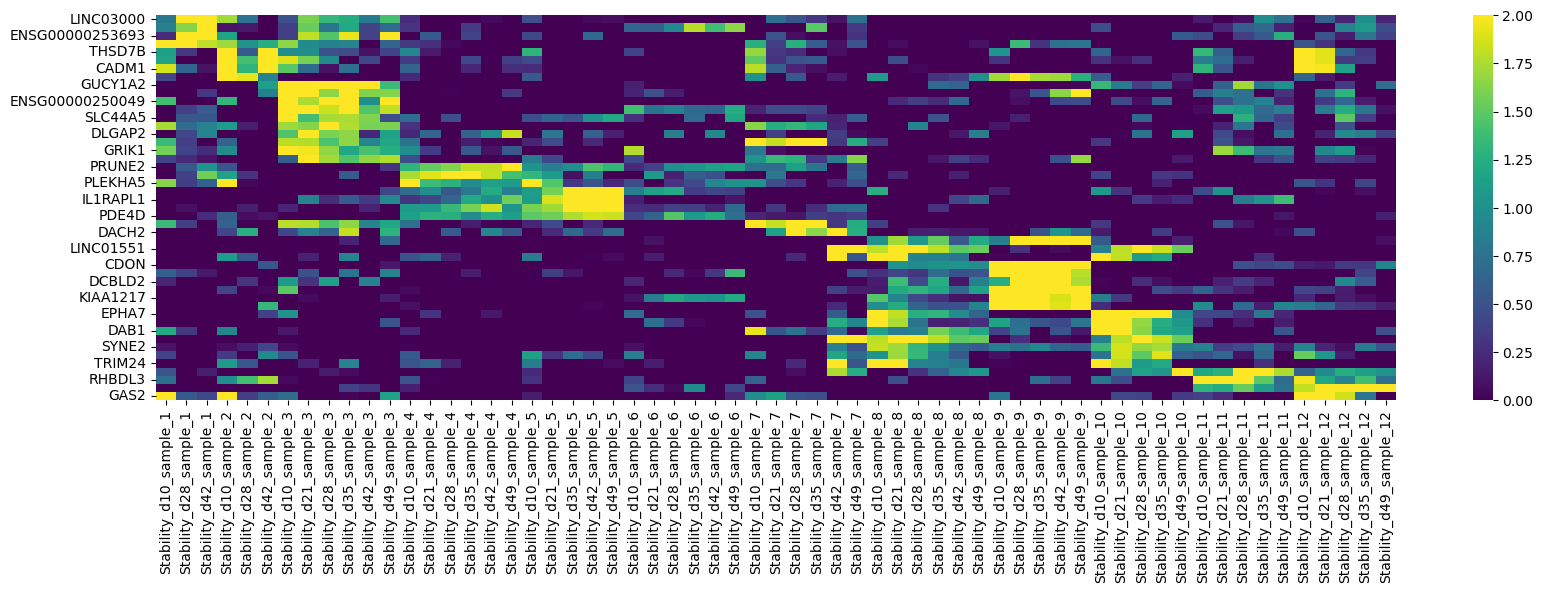

In [ ]:
# Create heatmap for overlapping markers
print("Creating heatmap for bulk-SC overlapping markers...")

if overlap_available and len(overlap_markers) > 0 and len(sorted_samples_meta) > 0:
    # Prepare overlap heatmap data
    vsd_overlap = vsd_df.loc[overlap_markers, sorted_samples_meta]
    vsd_overlap_z = (vsd_overlap.T - vsd_overlap.T.mean()) / vsd_overlap.T.std()
    vsd_overlap_z = vsd_overlap_z.T  # Transpose back
    
    plt.figure(figsize=FIGSIZE_LARGE)
    
    # Create heatmap
    sns.heatmap(vsd_overlap_z, 
                vmin=HEATMAP_VMIN, vmax=HEATMAP_VMAX,
                cmap='viridis',
                xticklabels=True, yticklabels=False,
                cbar_kws={'label': 'Z-score'})
    
    plt.title('Overlapping Markers: Bulk & Single-cell (No Filter)\n(Cross-validated Marker Genes)', 
              fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Sample ID', fontsize=12)
    plt.ylabel(f'Overlapping Markers (n={len(overlap_markers)})', fontsize=12)
    
    # Rotate x-axis labels
    plt.xticks(rotation=90, fontsize=8)
    
    # Save plot
    output_file = f"{PLOTS_DIR}/overlap_markers_bulk_sc_heatmap_noFilter.png"
    plt.savefig(output_file, dpi=DPI, bbox_inches='tight', pad_inches=0.1)
    print(f"Overlap heatmap saved to: {output_file}")
    
    plt.show()
    plt.close()
    
    print("✓ Overlapping markers heatmap created successfully!")
else:
    print("✗ Skipping overlap heatmap (insufficient overlapping markers)")



In [ ]:
## 12. Analysis Summary

In [ ]:
# Analysis Summary and Results
print("=== BULK RNA-SEQ STABILITY ANALYSIS SUMMARY (NO FILTER) ===")
print()

# Data summary
print("📊 DATA SUMMARY:")
if 'distance_df' in locals() and distance_df is not None:
    print(f"  • Samples analyzed: {distance_df.shape[0]}")
if 'meta_df' in locals() and meta_df is not None:
    print(f"  • Unique sample groups: {len(set(meta_df['sample']))}")
if 'vsd_df' in locals() and vsd_df is not None:
    print(f"  • Genes in VSD matrix (unfiltered): {vsd_df.shape[0]}")

print()
print("🧬 MARKER GENE ANALYSIS:")
if 'available_markers' in locals():
    print(f"  • Sample-specific markers: {len(available_markers)}")
if 'time_genes_available' in locals():
    print(f"  • Temporal markers: {len(time_genes_available)}")
if 'sc_markers_unique' in locals():
    print(f"  • Single-cell derived markers: {len(sc_markers_unique)}")
if 'overlap_markers' in locals():
    print(f"  • Bulk-SC overlapping markers: {len(overlap_markers)}")

print()
print("📈 VISUALIZATIONS CREATED:")
plots_created = []
for plot_file in ["dendrogram_colored_by_sample_noFilter.png", 
                  "dendrogram_colored_by_sample_heatmap_markers_noFilter.png",
                  "sample_heatmap_markers_sorted_noFilter.png",
                  "sample_heatmap_markers_time_sorted_noFilter.png",
                  "sample_heatmap_screen_markers_sorted.png",
                  "sc_markers_heatmap_minmax_noFilter.png",
                  "overlap_markers_bulk_sc_heatmap_noFilter.png"]:
    if os.path.exists(f"{PLOTS_DIR}/{plot_file}"):
        plots_created.append(plot_file)
        print(f"  ✓ {plot_file}")

# Check timepoint-specific plots
for timepoint in TIMEPOINTS_ANALYSIS:
    for plot_type in ['zscore', 'minmax']:
        plot_file = f"sc_markers_heatmap_{timepoint}_{plot_type}_noFilter.png"
        if os.path.exists(f"{PLOTS_DIR}/{plot_file}"):
            plots_created.append(plot_file)
            print(f"  ✓ {plot_file}")

print()
print("🔬 ANALYSIS INSIGHTS:")
print("  • NoFilter analysis includes complete gene expression profiles")
print("  • Hierarchical clustering reveals sample grouping patterns (unfiltered)")
print("  • Marker genes show distinct expression profiles across all genes")
print("  • Temporal analysis identifies early/late responsive genes (complete set)")
print("  • Timepoint-specific analysis provides focused D10/D28 insights")
if 'overlap_available' in locals() and overlap_available:
    print("  • Bulk and single-cell markers show significant overlap (unfiltered)")
else:
    print("  • Limited overlap between bulk and single-cell markers")

print()
print("🆚 NOFILTER VS FILTERED COMPARISON:")
print("  • Includes all expressed genes without pre-filtering")
print("  • May reveal additional patterns masked by filtering")
print("  • Provides comprehensive baseline for gene expression analysis")
print("  • Complements filtered analysis for complete perspective")

print()
print("📁 OUTPUT FILES:")
print(f"  • All plots saved to: {PLOTS_DIR}/")
print(f"  • Total plots created: {len(plots_created)}")
print(f"  • Timepoint-specific plots: {len([p for p in plots_created if any(t in p for t in TIMEPOINTS_ANALYSIS)])}")

print()
print("✅ BULK RNA-SEQ STABILITY ANALYSIS (NO FILTER) COMPLETED SUCCESSFULLY!")
print("=" * 70)